In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron
from sklearn.compose import ColumnTransformer

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Model evaluation und visualisation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimisation
from sklearn.model_selection import GridSearchCV


df = pd.read_csv("hotel.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# 1 Data preprocessing

## 1.1 Checking for Missing data

In [3]:
missing = df.isnull().sum(axis=0)
missing[missing!=0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [4]:
df.drop(['company'], axis=1, inplace=True)
df.children.fillna(df.children.mode()[0],inplace=True)
df.country.fillna(df.country.mode()[0],inplace=True)
df['agent'] = df['agent'].notna().astype(int)

In [5]:
# checking for data type
df['children']=df['children'].astype('int64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  int64  
 11  babies                          119390 non-null  int64  
 12  meal            

## 1.2 Checking for Duplicate Data

In [7]:
df.duplicated().sum()

0

## 1.3 Checking for Abnormal Data

In [8]:
zero_guest=df[df[['adults', 'children', 'babies']].sum(axis=1) == 0]
df.drop(zero_guest.index, inplace=True)

zero_days = df[df[['stays_in_weekend_nights','stays_in_week_nights']].sum(axis=1) == 0]
df.drop(zero_days.index, inplace=True)

df.meal.replace("Undefined", "SC", inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118565 entries, 2 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118565 non-null  object 
 1   is_canceled                     118565 non-null  int64  
 2   lead_time                       118565 non-null  int64  
 3   arrival_date_year               118565 non-null  int64  
 4   arrival_date_month              118565 non-null  object 
 5   arrival_date_week_number        118565 non-null  int64  
 6   arrival_date_day_of_month       118565 non-null  int64  
 7   stays_in_weekend_nights         118565 non-null  int64  
 8   stays_in_week_nights            118565 non-null  int64  
 9   adults                          118565 non-null  int64  
 10  children                        118565 non-null  int64  
 11  babies                          118565 non-null  int64  
 12  meal            

## 1.4 Adding columns

This project incorporated two additional columns for a more precise cost representation per booking. 'Total_family_size' quantifies the total count of adults, children, and babies per booking. 'Total_stay' aggregates stays during weekdays and weekends. We also introduced 'roomtype_change', a binary feature marking changes in room type during a stay, with 0 denoting no change and 1 indicating a change.

In [10]:
#add total family size column and total stay column
df['total_family_size']=df['adults']+df['children']+df['babies']
df['total_stay']=df['stays_in_weekend_nights']+df['stays_in_week_nights']
df['roomtype_change'] = np.where(df['reserved_room_type'] != df['assigned_room_type'], 1, 0)
df['adr_per_person'] = df['adr'] / (df['adults'] + df['children'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118565 entries, 2 to 119389
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118565 non-null  object 
 1   is_canceled                     118565 non-null  int64  
 2   lead_time                       118565 non-null  int64  
 3   arrival_date_year               118565 non-null  int64  
 4   arrival_date_month              118565 non-null  object 
 5   arrival_date_week_number        118565 non-null  int64  
 6   arrival_date_day_of_month       118565 non-null  int64  
 7   stays_in_weekend_nights         118565 non-null  int64  
 8   stays_in_week_nights            118565 non-null  int64  
 9   adults                          118565 non-null  int64  
 10  children                        118565 non-null  int64  
 11  babies                          118565 non-null  int64  
 12  meal            

# 2 Exploratory Analysis

Our project is divided into two primary phases: exploratory data analysis and predictive modelling. Initially, we undertake an exploration of the data to identify patterns, relationships, and trends that shed light on the dynamics of booking cancellations.

### 2.1 Correlation Analysis

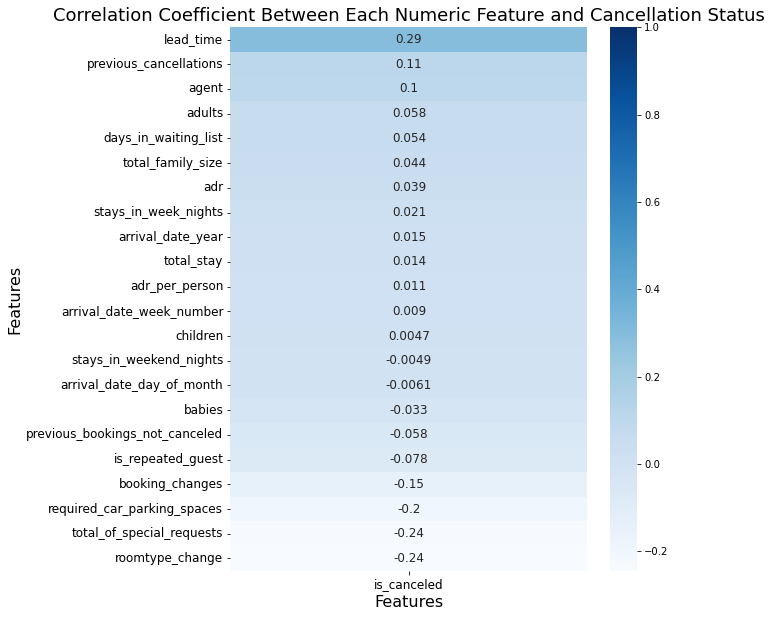

In [11]:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(df.corr()[['is_canceled']].sort_values('is_canceled', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Blues')
ax.set_title('Correlation Coefficient Between Each Numeric Feature and Cancellation Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

### 2.2 Leadtime Analysis

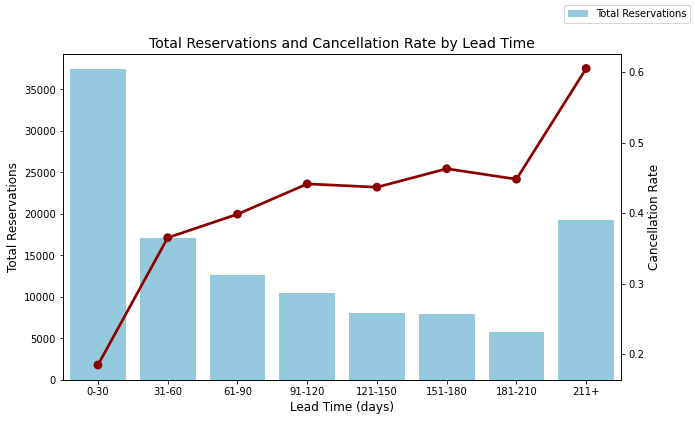

In [18]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Define bins
bins = [0, 30, 60, 90, 120, 150, 180, 210, df['lead_time'].max()+1]
labels = ['0-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-210', '211+']

# Apply bins to lead_time
df['lead_time_bin'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=False)

# Plot total reservations for each lead_time group
sns.countplot(data=df, x='lead_time_bin', ax=ax1, color='skyblue', label='Total Reservations')
ax1.set_xlabel('Lead Time (days)', fontsize=12)
ax1.set_ylabel('Total Reservations', fontsize=12)
ax1.tick_params(axis='y')

# Create a second y-axis for cancellation rates
ax2 = ax1.twinx()

# Compute and plot cancellation rate for each lead_time group
cancellation_rate = df[df['is_canceled'] == 1].groupby('lead_time_bin')['is_canceled'].count() / df.groupby('lead_time_bin')['is_canceled'].count()
sns.pointplot(x=cancellation_rate.index, y=cancellation_rate.values, ax=ax2, color='darkred', label='Cancellation Rate')
ax2.set_ylabel('Cancellation Rate', fontsize=12)

# Show the legend
fig.legend(loc="upper right")
plt.title('Total Reservations and Cancellation Rate by Lead Time', fontsize=14)

plt.show()

### 2.3 Customer Analysis

([<matplotlib.axis.XTick at 0x2878e661250>,
 [Text(0, 0, 'New Guest'), Text(1, 0, 'Repeated Guest')])

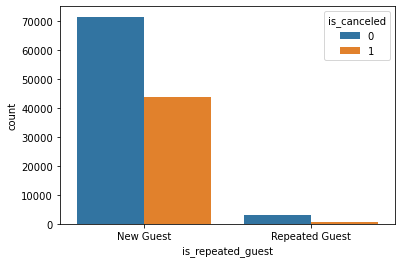

In [13]:
tick_label = ['New Guest', 'Repeated Guest']
sns.countplot(x='is_repeated_guest', hue='is_canceled', data=df)
plt.xticks([0, 1], tick_label)

Text(0.5, 0, 'Previous Un-Cancellations')

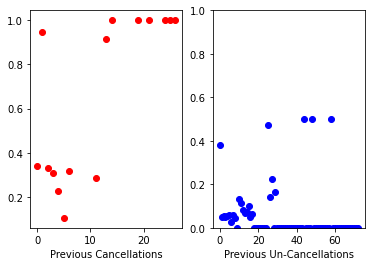

In [14]:
plt.subplot(121)
plt.plot(df.groupby('previous_cancellations')['is_canceled'].mean(),
         'ro')
plt.xlabel('Previous Cancellations')

plt.subplot(122)
plt.plot(df.groupby('previous_bookings_not_canceled')['is_canceled'].mean(),
         'bo')
plt.ylim(0, 1)
plt.xlabel('Previous Un-Cancellations')


### 2.4 Seasonality Analysis

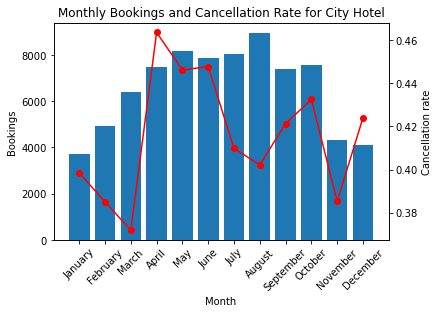

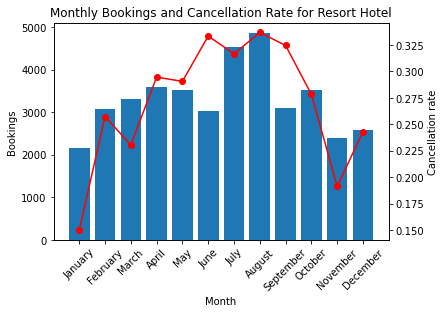

In [15]:
ordered_months = [
    "January", "February", "March", "April", "May", "June", "July", "August",
    "September", "October", "November", "December"
]

for hotel in ['City Hotel', 'Resort Hotel']:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    df_hotel = df[df.hotel == hotel]
    monthly = df_hotel.groupby('arrival_date_month').size()

    ax1.bar(np.arange(12), monthly[ordered_months])
    ax2.plot(np.arange(12), df_hotel.groupby('arrival_date_month')['is_canceled'].mean()[ordered_months].values, 'ro-')

    ax1.set_xlabel('Month')
    ax1.set_ylabel('Bookings')
    ax1.set_xticks(np.arange(12))
    ax1.set_xticklabels(ordered_months, rotation=45)
    ax1.set_title(f'Monthly Bookings and Cancellation Rate for {hotel}')

    ax2.set_ylabel('Cancellation rate')

### 2.5 Distribution Channel Analysis

Text(0, 0.5, 'Rate')

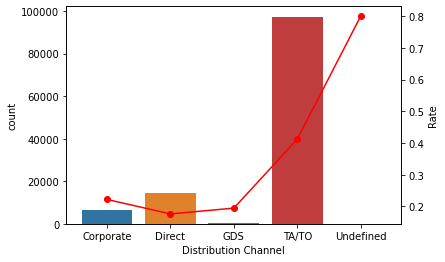

In [17]:
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.countplot(
    x=df['distribution_channel'],
    order =df.groupby('distribution_channel')['is_canceled'].mean().index,ax=ax1)

ax1.set_xlabel('Distribution Channel')
ax2.plot(df.groupby('distribution_channel')['is_canceled'].mean(), 'ro-')
ax2.set_ylabel('Rate')

# 3 Model Stage

### 3.1 Test-Train split

In [20]:
# Split the data
y = df['is_canceled'].copy()
X = df.drop(['is_canceled'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [21]:
print(X.shape)
print(y.shape)

(118565, 39)
(118565,)


### 3.2 Pre-process data

In [22]:
# Numerical columns
num_cols = ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
            'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled',
            'required_car_parking_spaces', 'total_of_special_requests',
            'adr_per_person', 'total_family_size', 'total_stay']

# Categorical columns for one-hot encoding, no feature is suitable for ordinal encoding
cat_cols = ['hotel', 'arrival_date_month', 'market_segment', 'distribution_channel',
            'deposit_type', 'customer_type', 'roomtype_change']

target = ['is_canceled']

train = df[num_cols + cat_cols + target].copy()

In [23]:
# Define the pipelines
num_pipeline = Pipeline(steps=[('std_scaler', StandardScaler())])
cat_pipeline = Pipeline(steps=[('one_hot_encoder', OneHotEncoder(drop='first'))])

# Combine pipelines in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

# Full pipeline
full_pipeline = Pipeline(steps=[ ('preprocessor', preprocessor)])

In [24]:
# Fit and transform the training data
X_train_prepared = full_pipeline.fit_transform(X_train)


In [25]:
print(X_train_prepared.shape)
print(y_train.shape)

(82995, 40)
(82995,)


# 4 Evaluate models

### 4.1 Logistic Regression

In [26]:
lr=LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_prepared,y_train)

# Predict on the training data
train_preds = lr.predict(X_train_prepared)

In [27]:
coefs=lr.coef_[0]                      # coeficient from the classifier
for (a,c) in zip(num_cols,coefs):
    # just the numeric; categorical needs to unpack the one hot encoding
    print('%8s: %5.4f' % (a,c) )

lead_time: 0.3952
arrival_date_week_number: -0.7543
arrival_date_day_of_month: 0.0768
is_repeated_guest: -0.0880
previous_cancellations: 2.2817
previous_bookings_not_canceled: -0.7457
required_car_parking_spaces: -6.6085
total_of_special_requests: -0.5714
adr_per_person: 0.1325
total_family_size: 0.2017
total_stay: 0.0721


In [28]:
# Perform cross-validation
scores = cross_val_score(lr, X_train_prepared, y_train,
                         scoring="accuracy", cv=10)

# Function to display scores
def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())

# Display cross-validation scores
display_scores(scores)


Mean:0.8125
Standard deviation:0.0048


### 4.2 Decision Tree

In [29]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_prepared, y_train)

train_preds = tree.predict(X_train_prepared)

In [30]:
# Perform cross-validation and calculate RMSE scores
scores = cross_val_score(tree, X_train_prepared, y_train,
                         scoring="accuracy", cv=10)

def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())


display_scores(scores)

Mean:0.8176
Standard deviation:0.0046


### 4.3 Random Forest

In [31]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train_prepared, y_train)

train_preds = forest.predict(X_train_prepared)


In [32]:
# Perform cross-validation
scores = cross_val_score(forest, X_train_prepared, y_train,
                         scoring="accuracy", cv=10)

def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())


display_scores(scores)

Mean:0.8619
Standard deviation:0.0048


In [33]:
feature_list=list(train.columns.drop(['is_canceled']))
importances = list(forest.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances=pd.DataFrame(feature_importances,columns=('features','importance'))
feature_importances.sort_values(by=['importance'],ascending = [False],inplace=True)
print(feature_importances)

                          features  importance
0                        lead_time        0.18
8                   adr_per_person        0.13
2        arrival_date_day_of_month        0.09
7        total_of_special_requests        0.06
10                      total_stay        0.06
1         arrival_date_week_number        0.06
4           previous_cancellations        0.05
9                total_family_size        0.02
6      required_car_parking_spaces        0.02
11                           hotel        0.01
5   previous_bookings_not_canceled        0.00
3                is_repeated_guest        0.00
12              arrival_date_month        0.00
13                  market_segment        0.00
14            distribution_channel        0.00
15                    deposit_type        0.00
16                   customer_type        0.00
17                 roomtype_change        0.00


In [34]:
import tensorflow as tf

In [35]:
pip install --upgrade keras tensorflow


### 4.4 Netural Network

In [36]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# validation split
X_train_prepared2, X_val, y_train2, y_val  = train_test_split(X_train_prepared, y_train, test_size=0.3, random_state=42)

# Create a function that returns a compiled model
def create_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(40,)))
    model.add(Dropout(0.18))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

if __name__ == "__main__":
    model_hotel = create_model()
    print(X_train_prepared2.shape)
    history = model_hotel.fit(X_train_prepared2, y_train2,
                   validation_data=(X_val,y_val),
                   epochs = 10)
    model_hotel.evaluate(X_val,y_val)

(58096, 40)
Epoch 1/10
1816/1816 [==============================] - 16s 6ms/step - loss: 0.5338 - accuracy: 0.7739 - val_loss: 0.4335 - val_accuracy: 0.8032
Epoch 2/10
1816/1816 [==============================] - 10s 6ms/step - loss: 0.4451 - accuracy: 0.8015 - val_loss: 0.4218 - val_accuracy: 0.8080
Epoch 3/10
1816/1816 [==============================] - 13s 7ms/step - loss: 0.4333 - accuracy: 0.8090 - val_loss: 0.4097 - val_accuracy: 0.8191
Epoch 4/10
1816/1816 [==============================] - 12s 6ms/step - loss: 0.4235 - accuracy: 0.8122 - val_loss: 0.4093 - val_accuracy: 0.8197
Epoch 5/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.4193 - accuracy: 0.8127 - val_loss: 0.4025 - val_accuracy: 0.8213
Epoch 6/10
1816/1816 [==============================] - 14s 8ms/step - loss: 0.4188 - accuracy: 0.8148 - val_loss: 0.4092 - val_accuracy: 0.8243
Epoch 7/10
1816/1816 [==============================] - 12s 7ms/step - loss: 0.4197 - accuracy: 0.8165 - val_loss: 0.4

### 4.5 Support Vector Machine

In [37]:
svm = SVC()
%time svm.fit(X_train_prepared, y_train)
train_preds = svm.predict(X_train_prepared)

CPU times: total: 22min 29s
Wall time: 24min 27s


In [38]:
%time svm_scores = cross_val_score(svm, X_train_prepared,y_train, scoring="accuracy", cv=5)

def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())

display_scores(svm_scores)

CPU times: total: 1h 18min 54s
Wall time: 1h 33min 35s
Mean:0.8199
Standard deviation:0.0034


#### Based on the mean of accuracy rate, we chose randomforest as our final model. In order to increase its accuracy rate, we used hyper-parameter to opitimise it. 

# 5 Hyper-parameter optimisation

In [39]:
param_grid = [
    {'n_estimators': [10, 50, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest, param_grid, cv=3,
                           scoring='accuracy', return_train_score=True)
%time grid_search.fit(X_train_prepared,y_train)

CPU times: total: 11min 13s
Wall time: 13min 30s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 50, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='accuracy')

In [40]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

forest = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_prepared, y_train)

print(grid_search.best_params_)

best_forest = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


# 6 Evaluation of the final model

In [44]:
final_model = best_forest


X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_accuracy = accuracy_score(y_test, final_predictions)
print('Accuracy: %5.4f' % final_accuracy)

Accuracy: 0.8633


### 6.1 Confusion Matrix

Confusion Matrix:
[[20613  1704]
 [ 3160 10093]]
F1 Score: 0.8058283433133733
Accuracy: 0.8632555524318246
Precision: 0.8555564974145969
Recall: 0.7615634196031087
F1 Score: 0.8058283433133733


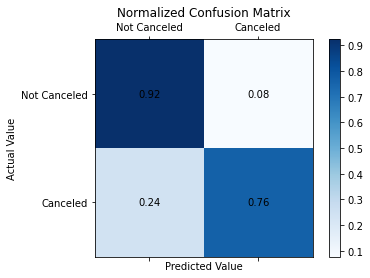

In [45]:
# Compute and print the confusion matrix
conf_mat = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(conf_mat)

# Re-import f1_score to solve type-error
from sklearn.metrics import f1_score

# calculate the f1_score again
f1 = f1_score(y_test, final_predictions)
print(f"F1 Score: {f1}")

# Compute and print accuracy, precision, recall, f1 score
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = ['Not Canceled', 'Canceled']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_normalized, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)
fig.colorbar(cax)

# Add the actual numbers in the cells of the confusion matrix
for (i, j), z in np.ndenumerate(conf_mat_normalized):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.show()

### 6.2 ROC

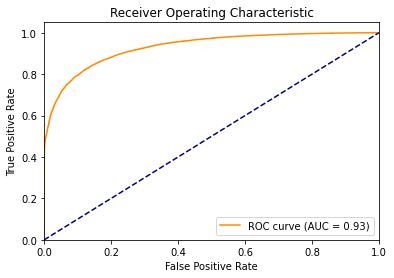

In [43]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities instead of binary predictions
y_scores = final_model.predict_proba(X_test_prepared)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
